In [53]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import datasets
import torchvision.transforms as transforms

In [54]:
class GrayscaleCIFAR100(Dataset):
    def __init__(self,root='./data', train=True, transform=None):
        self.cifar100 = datasets.CIFAR100(root=root, train=train, download=True)
        self.transform = transform
        self.grayscale = transforms.Grayscale()

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, index):
        image, label = self.cifar100[index]
        
        # Convert the image to grayscale
        
        grayscale_image = self.grayscale(image)

        # Apply transformations if provided
        if self.transform is not None:
            grayscale_image = self.transform(grayscale_image)
            image = self.transform(image)
        
        return grayscale_image, image

In [55]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

In [56]:
train_data = GrayscaleCIFAR100(
    root='./data',
    train=True,
    transform=transform
)

test_data = GrayscaleCIFAR100(
    root='./data',
    train=False,
    transform=transform
)
len(train_data), len(test_data)


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [57]:
import matplotlib.pyplot as plt
import numpy as np



# Get a batch of images
data_iter = iter(test_loader)
grayscaled, colored = next(data_iter)


torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


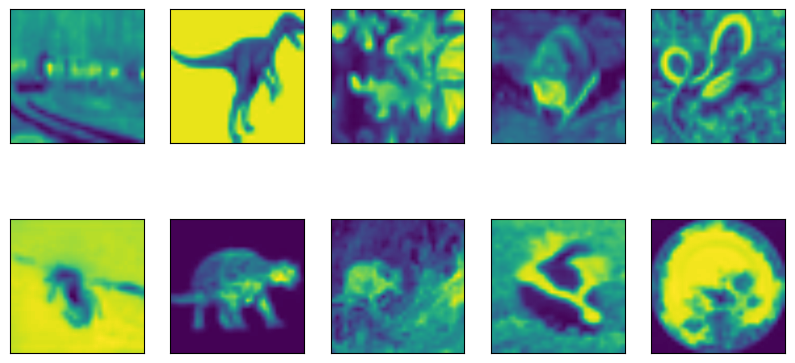

In [58]:
# Plot the images
fig = plt.figure(figsize=(10, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    gray = grayscaled[i] 
    print(gray.shape)
    gray = np.transpose(gray.numpy(), (1, 2, 0))
    ax.imshow(gray)
plt.show()

torch.Size([3, 256, 256])
(256, 256, 3)
torch.Size([3, 256, 256])
(256, 256, 3)
torch.Size([3, 256, 256])
(256, 256, 3)
torch.Size([3, 256, 256])
(256, 256, 3)
torch.Size([3, 256, 256])
(256, 256, 3)
torch.Size([3, 256, 256])
(256, 256, 3)
torch.Size([3, 256, 256])
(256, 256, 3)
torch.Size([3, 256, 256])
(256, 256, 3)
torch.Size([3, 256, 256])
(256, 256, 3)
torch.Size([3, 256, 256])
(256, 256, 3)


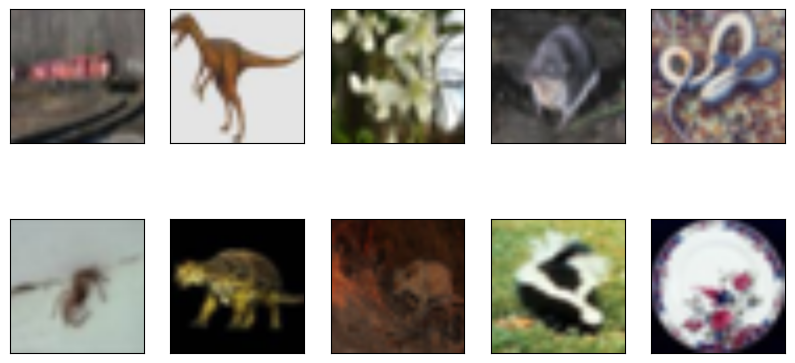

In [59]:
# Plot the images
fig = plt.figure(figsize=(10, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    color = colored[i] 
    print(color.shape)
    color = np.transpose(color.numpy(), (1, 2, 0))
    print(color.shape)
    ax.imshow(color)
plt.show()

In [60]:
relu = nn.ReLU()

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = relu(x)
        x = self.conv2(x)
        x = relu(x)
        return x


In [61]:
class DecoderConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # output_size = (input_size - 1) * stride + kernel_size - 2 * padding
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2) 
        self.conv = DoubleConv(out_channels + out_channels, out_channels)

    def forward(self, x, x1):
        y1 = self.up_conv(x)
        y2 = torch.cat((y1, x1), dim=-3)
        y = self.conv(y2)
        return y

In [62]:
class UNet(nn.Module):
    def __init__(self, size):
        super().__init__()

        # non trainable layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # trainable layers
        ## encoder 
        self.en_conv1 = DoubleConv(1,size)
        self.en_conv2 = DoubleConv(size,size*2)
        self.en_conv3 = DoubleConv(size*2,size*4)
        self.en_conv4 = DoubleConv(size*4,size*8)
        
        ## bottleneck
        self.conv = DoubleConv(size*8,size*16)

        ## decoder
        self.de_conv4 = DecoderConv(size*16,size*8)
        self.de_conv3 = DecoderConv(size*8,size*4)
        self.de_conv2 = DecoderConv(size*4,size*2)
        self.de_conv1 = DecoderConv(size*2,size)
        
        ## reconstruct layer
        self.reconstruct = nn.Conv2d(size, 3, kernel_size=3, padding=1)

    def forward(self, x):
      # encoder inference 
        # print(x.shape)
        e1 = self.en_conv1(x)
        p1 = self.pool(e1)
        # print(e1.shape)
        # print(p1.shape)
        
        e2 = self.en_conv2(p1)
        p2 = self.pool(e2)
        # print(e2.shape)
        # print(p2.shape)
        
        e3 = self.en_conv3(p2)
        p3 = self.pool(e3)
        # print(e3.shape)
        # print(p3.shape)
        
        e4 = self.en_conv4(p3)
        p4 = self.pool(e4)
        # print(e4.shape)
        # print(p4.shape)
      # bottleneck inference
        b = self.conv(p4)
        # print(b.shape)
      # decoder inference 
        d4 = self.de_conv4(b,e4)
        d3 = self.de_conv3(d4,e3)
        d2 = self.de_conv2(d3,e2)
        d1 = self.de_conv1(d2,e1)
        # print(d4.shape)
        # print(d3.shape)
        # print(d2.shape)
        # print(d1.shape)

      # reconstruct image
        colored_image = self.reconstruct(d1)
        # print(colored_image.shape)


        
        return colored_image

In [63]:
from torch import optim
from tqdm import tqdm

# Create data loaders
batch_size = 64
train_sampler = RandomSampler(train_data, replacement=False, num_samples=len(train_data)//8)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
test_sampler = RandomSampler(test_data, replacement=False, num_samples=len(test_data)//8)
test_loader = DataLoader(test_data, batch_size=batch_size, sampler=test_sampler)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set up training parameters
lr = 0.001
num_epochs = 10


# Initialize your U-Net model
model = UNet(4)
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
def train(model, trainloader, criterion, optimizer, progress_bar):
    model.train()
    running_loss = 0.0

    for grayscale_images, colored_images in progress_bar:
        grayscale_images = grayscale_images.to(device)
        colored_images = colored_images.to(device)

        # print(grayscale_images.shape)

        optimizer.zero_grad()

        # Forward pass
        predicted_images = model(grayscale_images)

        # Compute the loss
        loss = criterion(predicted_images, colored_images)

        # Backpropagation and weight updates
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss
    average_loss = running_loss / len(trainloader)

    return average_loss

# Evaluation loop
def evaluate(model, testloader, criterion, progressbar):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colored_images in progressbar:
            grayscale_images = grayscale_images.to(device)
            colored_images = colored_images.to(device)

            # Forward pass
            predicted_images = model(grayscale_images)

            # Compute the loss
            loss = criterion(predicted_images, colored_images)

            # Accumulate loss
            running_loss += loss.item()

    # Calculate average loss
    average_loss = running_loss / len(testloader)

    return average_loss


# Training and evaluation loop
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    pbar = tqdm(train_loader, leave=False)
    pbar.set_description(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train(model, train_loader, criterion, optimizer, pbar)
    print(f"Train Loss: {train_loss}")

    evalbar = tqdm(test_loader, leave=False)
    evalbar.set_description(f'Epoch {epoch+1}/{num_epochs}')
    val_loss = evaluate(model, test_loader, criterion, evalbar)
    print(f"Validation Loss: {val_loss}")


Epoch 1/10


Train Loss: 0.08359962487023095


Validation Loss: 0.032493249233812097
Epoch 2/10


Train Loss: 0.030980947332418695


Validation Loss: 0.031290456838905814
Epoch 3/10


Train Loss: 0.03027081139841858


Validation Loss: 0.030691835563629866
Epoch 4/10


Train Loss: 0.030206852820606863


Validation Loss: 0.030221453681588174
Epoch 5/10


Train Loss: 0.02900503923622321


Validation Loss: 0.027825972810387612
Epoch 6/10


Train Loss: 0.029388170005107413


Validation Loss: 0.029298760555684568
Epoch 7/10


Train Loss: 0.029682374692388942


Validation Loss: 0.03044132199138403
Epoch 8/10


Train Loss: 0.028250527073990325


Validation Loss: 0.030184793379157783
Epoch 9/10


Train Loss: 0.02810480109206876


Validation Loss: 0.027625741064548494
Epoch 10/10


Train Loss: 0.028251750850859954


Validation Loss: 0.02918421719223261


In [70]:
model.to("cpu")
input, label = test_data[0]
output = model(input)


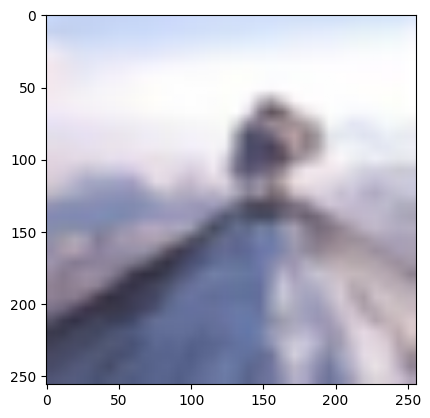

In [69]:

plt.imshow(label.permute((1,2,0)))


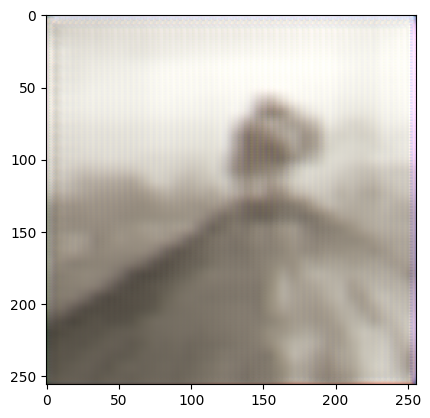

In [68]:

plt.imshow(output.detach().permute((1,2,0)))



In [79]:
output.detach().max(), output.detach().min() 

(tensor(1.1314), tensor(0.1634))

In [82]:
label.detach().max(), label.detach().min() 

(tensor(1.), tensor(0.1882))